In [2]:
import sys
sys.path.append("/home/jan/Documents/ETH/Masterarbeit/climada_python")
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import geopandas as gpd
from climada.hazard import Hazard
from scipy import sparse
import copy as cp
from matplotlib import pyplot as plt
from climada.entity import Exposures, Entity, LitPop
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import h5py
import hail_functions as fct
from sklearn.metrics import mean_squared_error
from scipy import optimize
import time
from scipy import stats
from scipy.stats import spearmanr

2021-02-09 13:30:04,779 - climada - DEBUG - Loading default config file: /home/jan/Documents/ETH/Masterarbeit/climada_python/climada/conf/defaults.conf


/home/jan/anaconda3/envs/climada_hail/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
# If any value in force_new_hdf5_generation is True the script will ask for 
# user input wether to overwrite the hdf5 with the new data
force_new_hdf5_generation ={"haz_real": False, 
                            "haz_synth": False, 
                            "haz_dur": False,
                            "exp_infr": False, 
                            "exp_agr": False}
name_hdf5_file={"haz_real": "haz_real.hdf5", 
                "haz_synth": "haz_synth.hdf5", 
                "haz_dur": "haz_dur.hdf5",
                "exp_infr": "exp_switzerland.hdf5", 
                "exp_agr": "exp_agr.hdf5"}

# Optimization
plot_img = False
haz_type = "HL"
ev_list = ["12/07/2011", "13/07/2011"]#["01/07/2019", "02/07/2019", "18/08/2019", "06/08/2019", "30/06/2019", "15/06/2019"]#, "01/07/2019", "18/06/2019"]
imp_fun_infr_meshs = {"imp_id": 1, "L": 0.1, "x_0": 100, "k": 10}
imp_fun_infr_dur = {"imp_id": 8, "L": 0.01, "x_0": 120, "k": 1}


imp_fun_parameter = [imp_fun_infr_meshs,
                     imp_fun_infr_dur]
# Path to Data 
input_folder = "/home/jan/Documents/ETH/Masterarbeit/input"
results_folder = "~/Documents/ETH/Masterarbeit/results"
years =["2002", "2003", "2004","2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018","2019"]


In [4]:
haz_real = fct.load_haz(force_new_hdf5_generation, "haz_real", name_hdf5_file, input_folder, years)
haz_dur = fct.load_haz(force_new_hdf5_generation, "haz_dur", name_hdf5_file, input_folder, years)

haz_real.check()
haz_dur.check()

if plot_img:
    haz_real.plot_fraction(0)
    haz_real.plot_intensity(0)
    haz_real.plot_fraction(-1)
    haz_real.plot_intensity(-1)
    haz_real.plot_rp_intensity(return_periods=(1, 5, 10, 20))
    haz_dur.plot_fraction(0)
    haz_dur.plot_intensity(0)
    haz_dur.plot_fraction(-1)
    haz_dur.plot_intensity(-1)
    haz_dur.plot_rp_intensity(return_periods=(1, 5, 10, 20))
#%% Impact_function

2021-02-09 13:30:09,692 - climada.hazard.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/haz_real.hdf5
2021-02-09 13:30:09,910 - climada.hazard.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/haz_dur.hdf5


2021-02-09 13:30:10,729 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:10,731 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


<IPython.core.display.Javascript object>


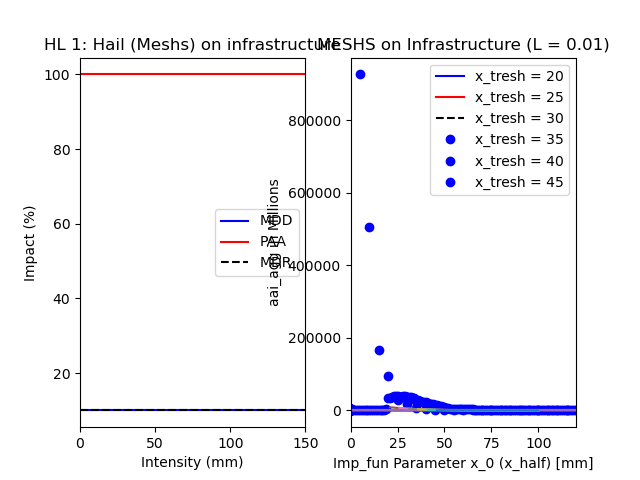

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f88206c2590>,
      dtype=object)

In [5]:
#%% Impact_function
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
ifset_hail = ImpactFuncSet()
for imp_fun_dict in imp_fun_parameter:
    imp_fun = fct.create_impact_func(haz_type, 
                                 imp_fun_dict["imp_id"], 
                                 imp_fun_dict["L"], 
                                 imp_fun_dict["x_0"], 
                                 imp_fun_dict["k"])
    imp_fun.mdd[:] = 0.1
    ifset_hail.append(imp_fun)
ifset_hail.plot()

In [6]:
#%% Exposure
exp_infr_meshs = fct.load_exp_infr(force_new_hdf5_generation, name_hdf5_file, input_folder, haz_real)
exp_infr_dur = exp_infr_meshs.copy()
exp_infr_dur["if_HL"] = 8 #change if_HL to match the corresponding imp_id
if plot_img:    
    exp_infr_meshs.plot_basemap()
    exp_infr_meshs.plot_hexbin()
    exp_infr_meshs.plot_scatter()
    exp_infr_meshs.plot_raster()



2021-02-09 13:30:12,929 - climada.entity.exposures.base - INFO - Reading /home/jan/Documents/ETH/Masterarbeit/input/exp_switzerland.hdf5
2021-02-09 13:30:13,505 - climada.entity.exposures.base - INFO - deductible not set.
2021-02-09 13:30:13,507 - climada.entity.exposures.base - INFO - cover not set.
2021-02-09 13:30:13,508 - climada.entity.exposures.base - INFO - category_id not set.


In [7]:
#%% Impact
imp_infr_meshs = Impact()
imp_infr_meshs.calc(exp_infr_meshs, ifset_hail, haz_real,save_mat=True)
# imp_infr.plot_raster_eai_exposure()
freq_curve_infr_meshs = imp_infr_meshs.calc_freq_curve()#[1, 2, 5, 10, 20])
if plot_img:
    freq_curve_infr_meshs.plot()
    imp_infr_meshs.plot_basemap_eai_exposure()
    imp_infr_meshs.plot_hexbin_eai_exposure()
    imp_infr_meshs.plot_scatter_eai_exposure()
    imp_infr_meshs.plot_raster_eai_exposure()

imp_infr_dur = Impact()
imp_infr_dur.calc(exp_infr_dur, ifset_hail, haz_dur, save_mat=True)
# imp_infr.plot_raster_eai_exposure()
freq_curve_infr_dur = imp_infr_dur.calc_freq_curve()
if plot_img:
    freq_curve_infr_dur.plot()
    imp_infr_dur.plot_basemap_eai_exposure()
    imp_infr_dur.plot_hexbin_eai_exposure()
    imp_infr_dur.plot_scatter_eai_exposure()
    imp_infr_dur.plot_raster_eai_exposure()



2021-02-09 13:30:14,250 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:14,254 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:14,773 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:14,776 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.


In [8]:
imp_fun_list = np.arange(0, 0.005, 0.0001)
dmg_for_imp_list = []
for i in imp_fun_list:
    ifset_hail = ImpactFuncSet()
    imp_fun = fct.create_impact_func(haz_type, 
                                 1, 
                                 1, 
                                 1, 
                                 1)
    imp_fun.mdd[:] = i
    ifset_hail.append(imp_fun)

    imp_infr_meshs.calc(exp_infr_meshs, ifset_hail, haz_real,save_mat=False)
    dmg_for_imp_list.append(imp_infr_meshs.aai_agg/1e6)

2021-02-09 13:30:16,228 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:16,230 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:16,236 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:16,372 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:16,373 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:16,376 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:16,523 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:30:18,932 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:18,934 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:19,081 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:19,081 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:19,084 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:19,227 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:19,227 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:30:21,743 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:21,744 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:21,746 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:21,893 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:21,893 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:21,896 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:22,038 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

In [9]:
plt.plot(imp_fun_list, dmg_for_imp_list, "bo")
plt.xlabel("% Affected Exposure")
plt.ylabel("aai_agg in Millions")
plt.title("MESHS on Infrastructure")
plt.show()

MESHS on Infrastructure:


Each point represents one Impact.calc() run. The Impactfunction for each point is constant and equal to the x-value. The y-Value represents the aai_agg for each of the calculations. We see that even extremely small values for %Affeced Exposure lead to huge aai_agg. 0.001% affected Exposure leads to around 1e9 damages to Infrastructure. 

In [10]:
imp_fun_list = np.arange(1, 150, 1)
dmg_for_imp_list = []
for i in imp_fun_list:
    ifset_hail = ImpactFuncSet()
    imp_fun = fct.create_impact_func(haz_type, 
                                 1, 
                                 1, 
                                 1, 
                                 1)
    imp_fun.mdd[:] = 0
    imp_fun.mdd[i] = 1.0
    ifset_hail.append(imp_fun)

    imp_infr_meshs.calc(exp_infr_meshs, ifset_hail, haz_real,save_mat=True)
    dmg_for_imp_list.append(imp_infr_meshs.aai_agg/1e6)
    


2021-02-09 13:30:25,920 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:25,925 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:25,927 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:26,053 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:26,054 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:26,056 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:26,169 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:30:28,047 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:28,050 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:28,178 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:28,179 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:28,181 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:28,336 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:28,337 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:30:30,746 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:30,746 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:30,749 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:30,880 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:30,880 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:30,883 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:31,010 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:30:32,964 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:32,966 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:33,078 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:33,079 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:33,081 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:33,194 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:33,195 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:30:35,152 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:35,153 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:35,155 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:35,263 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:35,264 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:35,266 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:35,379 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:30:37,221 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:37,223 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:37,329 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:37,330 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:37,332 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:37,443 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:37,444 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:30:39,391 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:39,392 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:39,395 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:39,511 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:39,512 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:39,514 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:39,626 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:30:41,530 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:41,532 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:41,643 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:41,644 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:41,647 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:41,758 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:41,759 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:30:43,778 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:43,779 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:43,781 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.


In [11]:
plt.plot(imp_fun_list, dmg_for_imp_list, "bo")
plt.xlabel("Meshs size [mm]")
plt.ylabel("aai_agg in Millions")
plt.title("MESHS on Infrastructure")
plt.show()

Each Point represents one Impact.calc() run. On the X_axis we see for what MESHS size the Impact was set to 1 (see next Figure to clarify). The y_axis shows the aai_agg for each of the Meshs sizes. This Figure shows the value of the affected exposure for each Meshs size.

Description Figure X: Affected exposure for Infrastructure in Millions [CHF] (y-axis) as a function of Meshs size (x-axis) [mm]. 

Figure X shows the affected exposure for Infrastructure as a function of Meshs size. Each point in the plots represents a model run where only the specified Meshs size is considered. From 21mm (smallest Meshs size in data) to 25mm there is an increase in affected exposure. Meshs sizes from 25mm to 30mm affect the most exposure. After 30mm there is a decline with a small bumb at around 60mm. 

In [12]:
imp_fun_list = np.arange(5, 120, 5)
dmg_for_imp_list = []
for i in imp_fun_list:
    ifset_hail = ImpactFuncSet()
    imp_fun = fct.create_impact_func(haz_type, 
                                 8, 
                                 1, 
                                 1, 
                                 1)
    imp_fun.mdd[:] = 0
    imp_fun.mdd[i] = 1.0
    ifset_hail.append(imp_fun)

    imp_infr_dur.calc(exp_infr_dur, ifset_hail, haz_dur,save_mat=True)
    dmg_for_imp_list.append(imp_infr_dur.aai_agg/1e6)
    


2021-02-09 13:30:45,952 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:45,953 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:45,956 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:46,486 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:46,486 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:46,489 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:46,838 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:30:49,338 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:49,341 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:49,487 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:49,488 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:49,491 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:49,628 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:49,628 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

In [13]:
plt.plot(imp_fun_list, dmg_for_imp_list, "bo")
plt.xlabel("Meshs size [mm]")
plt.ylabel("aai_agg in Millions")
plt.title("MESHS on Infrastructure")
plt.show()

## Finding an Impact function

In [14]:
x_tresh_list = np.arange(20, 80, 30)
L = 1
label = []
for x_tresh in x_tresh_list:
    imp_fun_param_list = np.arange(x_tresh+1, 111, 30)
    dmg_for_imp_fun_param = []
    for i in imp_fun_param_list:
        y = fct.sigmoid2(np.arange(0, 150), L = L, x_0 = i, x_tresh = x_tresh)
        ifset_hail = ImpactFuncSet()
        imp_fun = fct.create_impact_func(haz_type, 1, 1, 1, 1, y = y)
        ifset_hail.append(imp_fun)
        plt.plot(y)
        label.append("x_tresh = {}; x_half = {}".format(x_tresh, i))
plt.title("Impfun Meshs on Infr, L = {}".format(L))
plt.xlabel("Intensity [mm]")
plt.ylabel("Impact [%]")
plt.legend(labels=label)
plt.show()

2021-02-09 13:30:52,259 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:52,262 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:52,265 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:52,268 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:52,271 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or pa

The Impact function describes how the hazzards intensity impacts the affected exposure. Figure X shows 

In [15]:
labels = []
for x_tresh in np.arange(20, 50, 5):
    L = 0.01
    x_tresh = x_tresh
    imp_fun_param_list = np.arange(x_tresh+1, 101, 1)
    dmg_for_imp_fun_param = []
    for i in imp_fun_param_list:
        y = fct.sigmoid2(np.arange(0, 150), L = L, x_0 = i, x_tresh = x_tresh)
        ifset_hail = ImpactFuncSet()
        imp_fun = fct.create_impact_func(haz_type, 1, 1, 1, 1, y = y)
        ifset_hail.append(imp_fun)

        imp_infr_meshs.calc(exp_infr_meshs, ifset_hail, haz_real,save_mat=False)
        dmg_for_imp_fun_param.append(imp_infr_meshs.aai_agg/1e6)
    labels.append("x_tresh = {}".format(x_tresh))
    plt.plot(imp_fun_param_list, dmg_for_imp_fun_param)
    plt.xlabel("Imp_fun Parameter x_0 (x_half) [mm]")
    plt.ylabel("aai_agg in Millions")
    plt.title("MESHS on Infrastructure (L = {})".format(L))
plt.legend(labels)
plt.show()

2021-02-09 13:30:53,640 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:53,642 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:53,645 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:53,823 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:53,823 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:53,826 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:53,979 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:30:56,406 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:56,408 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:56,564 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:56,565 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:56,568 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:56,712 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:56,713 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:30:59,255 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:59,256 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:59,259 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:59,402 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:30:59,403 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:30:59,405 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:30:59,551 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:31:02,072 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:02,074 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:02,221 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:02,222 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:02,224 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:02,370 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:02,370 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:31:05,277 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:05,278 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:05,280 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:05,427 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:05,428 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:05,430 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:05,575 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:31:07,834 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:07,836 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:07,972 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:07,972 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:07,975 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:08,109 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:08,110 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:31:10,435 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:10,436 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:10,439 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:10,573 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:10,574 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:10,576 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:10,718 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:31:12,917 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:12,920 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:13,052 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:13,053 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:13,055 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:13,193 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:13,193 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:31:15,526 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:15,527 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:15,530 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:15,666 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:15,667 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:15,669 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:15,799 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:31:18,103 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:18,106 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:18,237 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:18,238 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:18,241 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:18,365 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:18,365 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:31:20,586 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:20,587 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:20,590 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:20,715 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:20,715 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:20,718 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:20,849 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:31:22,951 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:22,953 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:23,076 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:23,076 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:23,079 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:23,207 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:23,207 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:31:25,453 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:25,454 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:25,456 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:25,585 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:25,585 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:25,588 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:25,714 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:31:27,699 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:27,701 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:27,822 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:27,823 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:27,825 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:27,950 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:27,951 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:31:30,053 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:30,053 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:30,056 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:30,174 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:30,174 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:30,177 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:30,303 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:31:32,283 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:32,285 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:32,401 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:32,402 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:32,405 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:32,527 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:32,528 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:31:34,605 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:34,605 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:34,608 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:34,734 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:34,735 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:34,737 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:34,850 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:31:36,761 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:36,763 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:36,882 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:36,883 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:36,885 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:37,002 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:37,002 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:31:39,010 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:39,011 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:39,014 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:39,127 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:39,128 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:39,131 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:39,244 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:31:41,108 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:41,110 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:41,220 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:41,220 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:41,223 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:41,338 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:41,338 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:31:43,305 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:43,306 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:43,308 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:43,419 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:43,420 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:43,422 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:43,541 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:31:45,405 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:45,407 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:45,523 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:45,524 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:31:45,526 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:31:45,637 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:31:45,638 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

Here we have a sensitivity analysis for x_0 (x_axis). Other parameter are fixed (see plot Title). 

Here we have damages from the vkg
https://www.vkg.ch/media/1949/saeulen_ele_hagel_2019_kl.png?width=720

dmg_vkg_infr = [34.4, 59.6, 16.7, 128.9, 25.6, 80.2, 136.3, 21.6, 25.2, 14.7, 260.1, 12.6, 200.4, 63.8, 157.4, 7.5, 21.3, 14.3, 50.7, 24.6, 13.8]

These numbers need to be ajusted. First letzt look at the excluded cantons, the so called GUSTAVO cantons (GUSTAVO-Kantonen: Genf, Uri, Schwyz, Tessin, Appenzell Innerrhoden, Wallis (VS) und Obwalden). 

An sensible approximation would be to say that the worth of the infrastructure is comparable to the BIP of these cantons. 

So if we want to scale the values we can divide by the BIP of the Kantons in the VKG and then multiply by the BIP of Switzerland. 
(Source: https://www.bfs.admin.ch/bfs/de/home/statistiken/volkswirtschaft/volkswirtschaftliche-gesamtrechnung/bruttoinlandprodukt-kanton.html)

BIP of Switzerland without GUSTAVO: 558.313
Bip of Switzerland with GUSTAVO: 669.542

so wenn we do dmg_vkg_infr_adjust = dmg_vkg_infr / 558.313 * 669.542
we get:
dmg_vkg_infr_adjust = 
array([ 41.25328409,  71.47371313,  20.02703036, 154.579893  ,
        30.70011839,  96.17771465, 163.45414597,  25.90322489,
        30.22042904,  17.62858361, 311.91799976,  15.11021452,
       240.32436429,  76.51045131, 188.75775918,   8.99417531,
        25.54345788,  17.14889426,  60.8006251 ,  29.50089502, 16.55])

In the next step we ned to adjust for inflation (teuerung): 

dmg_vkg_infr_adj_infr = [45.36, 77.37, 21.39, 164.27, 32.35, 101.18, 169.90, 26.60, 31.00, 17.66, 311.96, 14.96, 237.43 , 76.12, 188.37, 8.98, 25.60, 17.15, 60.80, 29.50, 16.55]

we also leave away the years before 2002:

dmg_vkg_infr_adj_infr = [164.27, 32.35, 101.18, 169.90, 26.60, 31.00, 17.66, 311.96, 14.96, 237.43 , 76.12, 188.37, 8.98, 25.60, 17.15, 60.80, 29.50, 16.55]

If we load this into CLIMADA and calculate the frequency exceedance curve we get: 

<IPython.core.display.Javascript object>


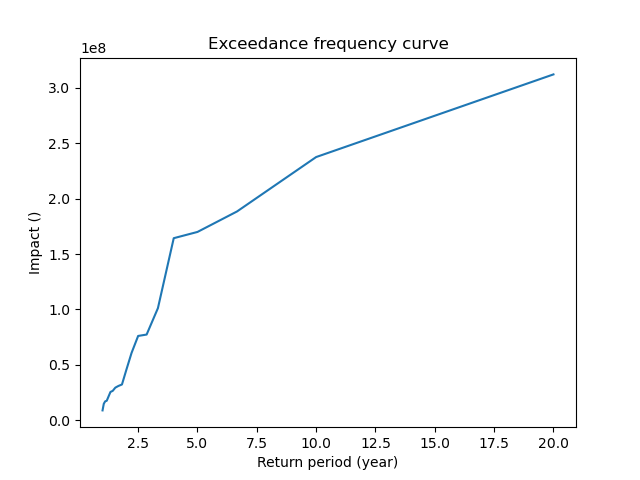

In [16]:
vkg_data = [45.36, 77.37, 21.39, 164.27, 32.35, 101.18, 169.90, 26.60, 31.00, 17.66, 311.96, 14.96, 237.43 , 76.12, 188.37, 8.98, 25.60, 17.15, 60.80, 29.50]
vkg_data = [int(i*1e6) for i in vkg_data] 
imp_vkg = Impact()
imp_vkg.at_event = np.asarray(vkg_data)
imp_vkg.frequency = np.ones(len(imp_vkg.at_event))/len(imp_vkg.at_event)
imp_vkg_freq_curve = imp_vkg.calc_freq_curve()
imp_vkg_freq_curve.plot()

In [17]:
def get_exceedance_curves(which_val = 0):
    # which val is for which position will all graphs be the same. 0-> first, -1 > last
    vkg_val_for_fact = imp_vkg_freq_curve.impact[which_val]
    freq_curve_list = []
    label = []
    for x_tresh in np.arange(20, 81, 20):
        L = 1.0
        x_tresh = x_tresh
        imp_fun_param_list = np.arange(x_tresh+1, 131, 30)
        dmg_for_imp_fun_param = []
        for i in imp_fun_param_list:
            y = fct.sigmoid2(np.arange(0, 150), L = L, x_0 = i, x_tresh = x_tresh)
            ifset_hail = ImpactFuncSet()
            imp_fun = fct.create_impact_func(haz_type, 1, 1, 1, 1, y = y)
            ifset_hail.append(imp_fun)
            imp_infr_meshs = Impact()
            imp_infr_meshs.calc(exp_infr_meshs, ifset_hail, haz_real,save_mat=False)
            freq_curve = imp_infr_meshs.calc_freq_curve(imp_vkg_freq_curve.return_per)
            freq_curve = freq_curve.impact
            L_fact = vkg_val_for_fact / freq_curve[which_val]
            L *= L_fact
            freq_curve *= L_fact
            freq_curve_list.append([freq_curve])
            label.append("x_t={}, x_h={}, L={:2.2e}".format(x_tresh, i, L))
    return label, freq_curve_list

In [18]:
def get_exceedance_curves2(which_val = 0,
                           range_x_tresh = np.arange(20,81,20),
                           range_x_half = np.arange(80, 150, 30)):
    # which val is for which position will all graphs be the same. 0-> first, -1 > last
    if range_x_half[0]<= range_x_tresh[0]:
        print("Error: x_half smaller than x_tresh")
        return
    vkg_val_for_fact = imp_vkg_freq_curve.impact[which_val]
    freq_curve_list = []
    label = []
    for x_tresh in range_x_tresh:
        L = 1.0
        imp_fun_param_list = np.arange(x_tresh+1, 131, 30)
        dmg_for_imp_fun_param = []
        for x_half in range_x_half:
            y = fct.sigmoid2(np.arange(0, 150), L = L, x_0 = x_half, x_tresh = x_tresh)
            ifset_hail = ImpactFuncSet()
            imp_fun = fct.create_impact_func(haz_type, 1, 1, 1, 1, y = y)
            ifset_hail.append(imp_fun)
            imp_infr_meshs = Impact()
            imp_infr_meshs.calc(exp_infr_meshs, ifset_hail, haz_real,save_mat=False)
            freq_curve = imp_infr_meshs.calc_freq_curve(imp_vkg_freq_curve.return_per)
            freq_curve = freq_curve.impact
            L_fact = vkg_val_for_fact / freq_curve[which_val]
            L *= L_fact
            freq_curve *= L_fact
            freq_curve_list.append([freq_curve])
            rmsf = RMSF(freq_curve, imp_vkg_freq_curve.impact)
            label.append("x_t={}, x_h={}, L={:2.3e}, RMSF ={:.2f}".format(x_tresh, x_half, L, rmsf))
    return label, freq_curve_list

In [19]:
def RMSF(X, Y):
    """
    Calculate the Root Mean Squared Fraction (RMSF)
    
    Parameters
    ----------
    X : np.ndarray
        Values from CLIMADA.
    Y : np.ndarray
        Values from observations.

    Returns
    -------
    sol : float
        Result of RMSF for X and Y.

    """
    res = 0
    for i in range(len(X)):

        res += np.log(Y[i]/X[i])**2
    res = np.exp((res/len(X))**(1/2))
    return res

2021-02-09 13:32:15,568 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:32:15,572 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:32:15,576 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:32:15,769 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:32:15,770 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:32:15,773 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:32:15,930 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

<IPython.core.display.Javascript object>


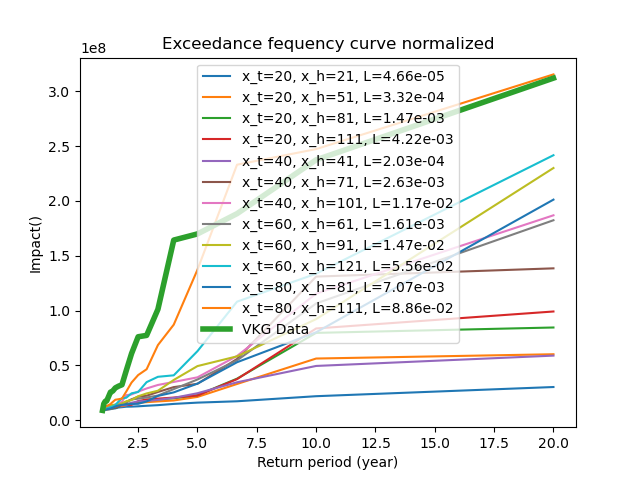

In [20]:
%matplotlib notebook
label, freq_curve_list = get_exceedance_curves(which_val = 0)
for i in freq_curve_list:
    plt.plot(imp_vkg_freq_curve.return_per, i[0])
plt.title("Exceedance fequency curve normalized")
plt.xlabel("Return period (year)")
plt.ylabel("Impact()")
plt.plot(imp_vkg_freq_curve.return_per, imp_vkg_freq_curve.impact, linewidth = 4)
label.append("VKG Data")
plt.legend(label)
plt.show()

2021-02-09 13:33:14,327 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:14,338 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:14,344 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:14,542 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:14,543 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:14,546 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:14,715 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

<IPython.core.display.Javascript object>


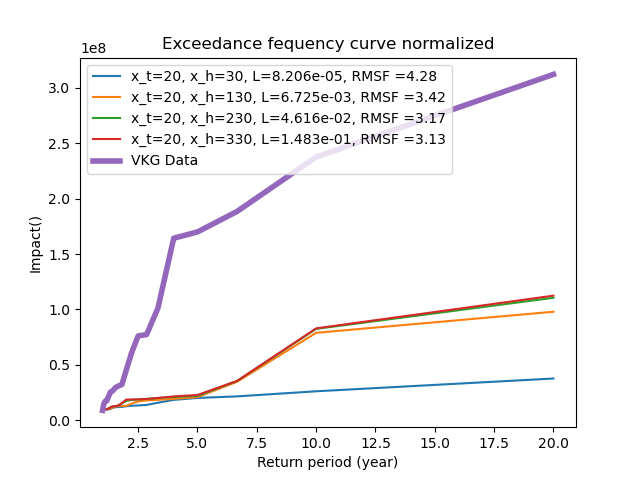

In [21]:
%matplotlib notebook
x_tresh = np.arange(20, 21, 10)
x_half = np.arange(30, 331, 100 )
label, freq_curve_list = get_exceedance_curves2(0, x_tresh, x_half)
for i in freq_curve_list:
    plt.plot(imp_vkg_freq_curve.return_per, i[0])
plt.title("Exceedance fequency curve normalized")
plt.xlabel("Return period (year)")
plt.ylabel("Impact()")
plt.plot(imp_vkg_freq_curve.return_per, imp_vkg_freq_curve.impact, linewidth = 4)
label.append("VKG Data")
plt.legend(label)
plt.show()

we see for a fixed x_t = 20 the x_h approximates a stable solution prety fast. For further Testing I would like to continue with the parameter combination x_t = 20; x_h = 230; L = 4.616e-02

2021-02-09 13:33:16,960 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:16,962 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:16,965 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:17,135 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:17,136 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:17,138 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:17,262 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

<IPython.core.display.Javascript object>


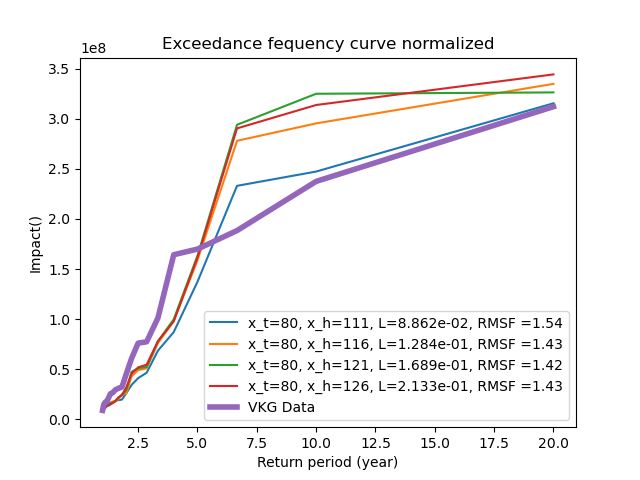

In [22]:
%matplotlib notebook
x_tresh = np.arange(80, 81, 1)
x_half = np.arange(111, 131, 5 )
label, freq_curve_list = get_exceedance_curves2(0, x_tresh, x_half)
for i in freq_curve_list:
    plt.plot(imp_vkg_freq_curve.return_per, i[0])
plt.title("Exceedance fequency curve normalized")
plt.xlabel("Return period (year)")
plt.ylabel("Impact()")
plt.plot(imp_vkg_freq_curve.return_per, imp_vkg_freq_curve.impact, linewidth = 4)
label.append("VKG Data")
plt.legend(label)
plt.show()

Its hard to say whicht of the displayed curves matches the VKG one the best. While (x_t = 80; x_h=111, L=8.862e-2) matches the higher return periods quite well it is worst for the smaller ones. Also the differences there are bigger than they seem on first look.

Based on this small analysis i will continue with the following two curves:  
Curve 1: x_t = 20; x_h = 230; L = 4.616e-02  
Curve 2: x_t = 80; x_h=121, L=1.689e-1  
  
In the further analysis we will use these two curves and look at the Impact CLIMADA generates with those.

In [23]:
#Ignore this, it does not work because of how L is defined!

def get_exceedance_curves3(which_val = 0,
                           range_x_tresh = np.arange(20,81,20),
                           range_x_half = np.arange(80, 150, 30),
                           range_x_max = np.array([80])):
    # which val is for which position will all graphs be the same. 0-> first, -1 > last
    if range_x_half[0]<= range_x_tresh[0]:
        print("Error: x_half smaller than x_tresh")
        return
    vkg_val_for_fact = imp_vkg_freq_curve.impact[which_val]
    freq_curve_list = []
    label = []
    for x_tresh in range_x_tresh:
        L = 1.0
        imp_fun_param_list = np.arange(x_tresh+1, 131, 30)
        dmg_for_imp_fun_param = []
        for x_half in range_x_half:
            for x_max in range_x_max:
                y = fct.sigmoid2(np.arange(0, 150), L = L, x_0 = x_half, x_tresh = x_tresh)
                y_max = y[x_max]
                y = [min(i, y_max) for i in y]
                ifset_hail = ImpactFuncSet()
                imp_fun = fct.create_impact_func(haz_type, 1, 1, 1, 1, y = y)
                ifset_hail.append(imp_fun)

                imp_infr_meshs.calc(exp_infr_meshs, ifset_hail, haz_real,save_mat=False)
                freq_curve = imp_infr_meshs.calc_freq_curve(imp_vkg_freq_curve.return_per)
                freq_curve = freq_curve.impact
                L_fact = vkg_val_for_fact / freq_curve[which_val]
                L *= L_fact
                freq_curve *= L_fact
                freq_curve_list.append([freq_curve])
                label.append("x_t={}, x_h={}, L={:2.3e}, x_max = {}".format(x_tresh, x_half, L, x_max))
    return label, freq_curve_list

# Investigation Curve 1 (x_t = 20; x_h = 230; L = 4.616e-02  )

2021-02-09 13:33:19,919 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


<IPython.core.display.Javascript object>


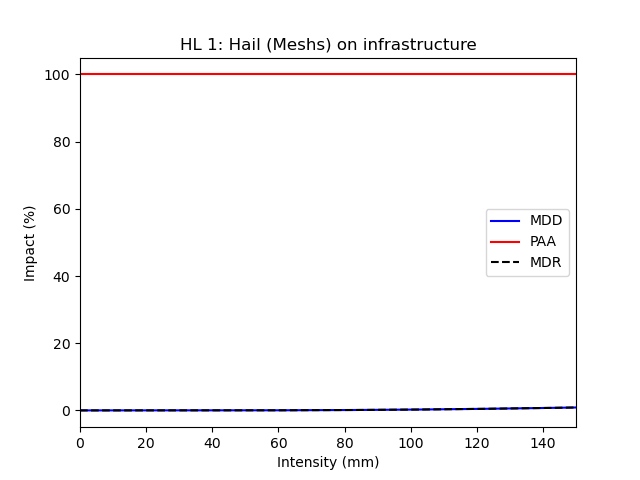

In [24]:
y = fct.sigmoid2(np.arange(0,150), L = 4.616e-02, x_0 = 230, x_tresh = 20) 
ifset_hail = ImpactFuncSet()
imp_fun = fct.create_impact_func(haz_type, 1,1,1,1,y = y)
imp_fun_curve_1 = imp_fun
ifset_hail.append(imp_fun)
ifset_hail.plot()

In [25]:
#Calc Impact
imp_infr_meshs_curve_1 = Impact()
imp_infr_meshs_curve_1.calc(exp_infr_meshs, ifset_hail, haz_real, save_mat = True)

2021-02-09 13:33:21,134 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:21,138 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.


<IPython.core.display.Javascript object>


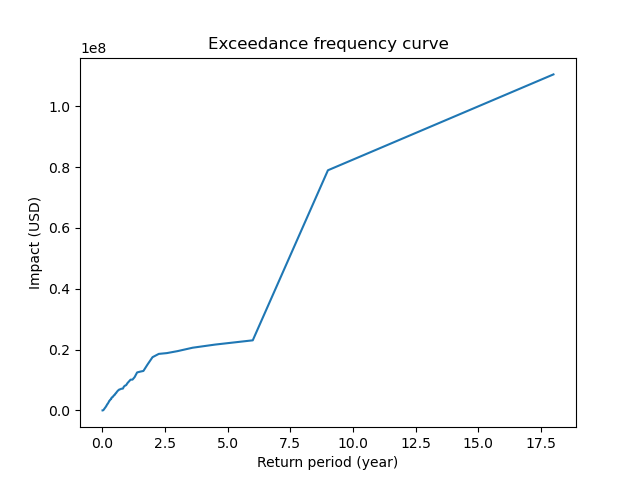

In [26]:
#Plot Freq curve:
#Note for calc_freq_curve one can chage the return periods.
#use 'imp_vkg_freq_curve.return_per' If you want to have the same as there
imp_infr_meshs_curve_1_freq_curve = imp_infr_meshs_curve_1.calc_freq_curve()
imp_infr_meshs_curve_1_freq_curve.plot()

In [27]:
print("the aai_agg is {:02.1f} Mio".format(imp_infr_meshs_curve_1.aai_agg/1e6))

the aai_agg is 53.2 Mio


In [28]:
%matplotlib notebook

#imp_infr_meshs_curve_1.plot_basemap_eai_exposure()

In [29]:
# Get the damage for every Meshs size
y = fct.sigmoid2(np.arange(0,150), L = 4.616e-02, x_0 = 230, x_tresh = 20) 
ifset_hail = ImpactFuncSet()
imp_fun = fct.create_impact_func(haz_type, 1,1,1,1,y = y)
imp_fun_curve_1 = imp_fun.mdd
dmg_meshs_size = []
dmg_meshs_size_year = np.zeros((150, 18))
dmg_meshs_size_year_label = []
meshs_size = np.arange(0, 150)
for i in meshs_size:
    y = np.zeros(150)
    y[i] = imp_fun_curve_1[i]
    imp_fun = fct.create_impact_func(haz_type, 1, 1, 1, 1, y = y)
    ifset_hail = ImpactFuncSet()
    ifset_hail.append(imp_fun)
    imp = Impact()
    imp.calc(exp_infr_meshs, ifset_hail, haz_real, save_mat = True)
    yearly = imp.calc_impact_year_set()
    for count, i2 in enumerate(yearly):
        dmg_meshs_size_year[i, count] = yearly[i2]
        dmg_meshs_size_year_label.append(i2)
    dmg_meshs_size.append(imp.aai_agg)

2021-02-09 13:33:24,942 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:24,944 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:24,946 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:24,949 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:25,077 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:25,078 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-

2021-02-09 13:33:27,100 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:27,101 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:27,103 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:27,216 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:27,217 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:27,219 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:27,332 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:33:29,636 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:29,638 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:29,767 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:29,768 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:29,770 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:29,900 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:29,901 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:33:32,043 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:32,044 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:32,047 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:32,168 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:32,169 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:32,172 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:32,287 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:33:34,173 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:34,176 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:34,290 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:34,291 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:34,294 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:34,409 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:34,410 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:33:36,396 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:36,398 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:36,400 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:36,514 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:36,515 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:36,518 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:36,631 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:33:38,498 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:38,501 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:38,613 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:38,614 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:38,616 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:38,729 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:38,730 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:33:40,713 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:40,714 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:40,717 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:40,831 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:40,832 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:40,835 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:40,947 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:33:42,822 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:42,825 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:42,945 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:42,946 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:33:42,948 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:33:43,061 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:33:43,062 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

<IPython.core.display.Javascript object>


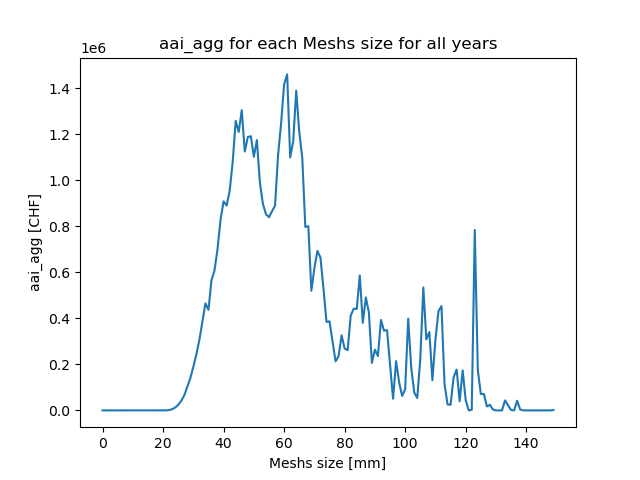

Text(0.5, 1.0, 'aai_agg for each Meshs size for all years')

In [30]:
%matplotlib notebook
plt.plot(meshs_size, dmg_meshs_size)
plt.xlabel("Meshs size [mm]")
plt.ylabel("aai_agg [CHF]")
plt.title("aai_agg for each Meshs size for all years")

In [31]:
#check if plot above is right
print(sum(dmg_meshs_size))
print(imp_infr_meshs_curve_1.aai_agg)

53246010.01424251
53246010.01424249


<IPython.core.display.Javascript object>


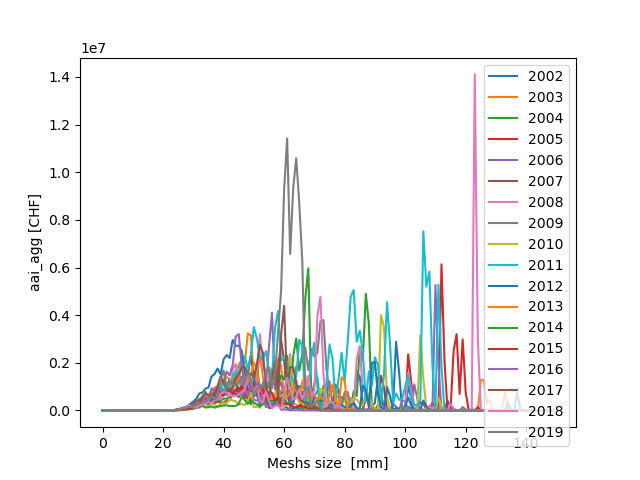

Text(0, 0.5, 'aai_agg [CHF]')

In [32]:
%matplotlib notebook
for i in range(dmg_meshs_size_year.shape[1]):
    plt.plot(meshs_size, dmg_meshs_size_year[:,i])
plt.legend(labels = dmg_meshs_size_year_label)
plt.xlabel("Meshs size  [mm]")
plt.ylabel("aai_agg [CHF]")

# Investigation Curve 2 (x_t = 80; x_h=111, L=8.862e-2)

2021-02-09 13:34:03,585 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


<IPython.core.display.Javascript object>


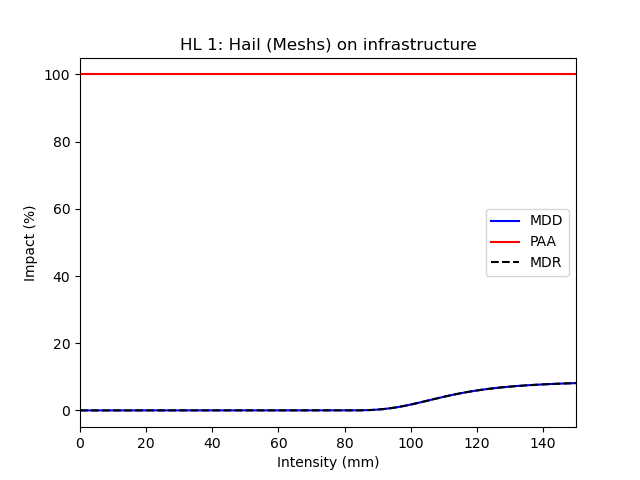

In [33]:
y = fct.sigmoid2(np.arange(0,150), L = 8.862e-02, x_0 = 111, x_tresh = 80) 
ifset_hail = ImpactFuncSet()
imp_fun = fct.create_impact_func(haz_type, 1,1,1,1,y = y)
imp_fun_curve_1 = imp_fun
ifset_hail.append(imp_fun)
ifset_hail.plot()

In [34]:
#Calc Impact
imp_infr_meshs_curve_2 = Impact()
imp_infr_meshs_curve_2.calc(exp_infr_meshs, ifset_hail, haz_real, save_mat = True)

2021-02-09 13:34:05,036 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:05,042 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.


<IPython.core.display.Javascript object>


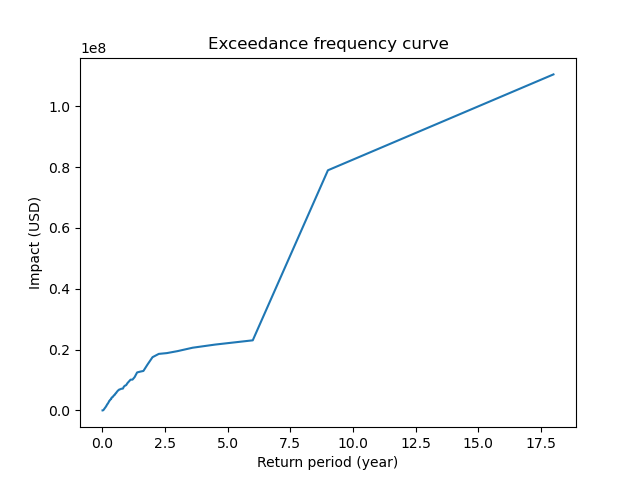

In [35]:
#Plot Freq curve:
#Note for calc_freq_curve one can chage the return periods.
#use 'imp_vkg_freq_curve.return_per' If you want to have the same as there
imp_infr_meshs_curve_2_freq_curve = imp_infr_meshs_curve_1.calc_freq_curve()
imp_infr_meshs_curve_2_freq_curve.plot()

In [36]:
print("the aai_agg is {:02.1f} Mio".format(imp_infr_meshs_curve_2.aai_agg/1e6))

the aai_agg is 75.9 Mio


In [37]:
# Get the damage for every Meshs size
y = fct.sigmoid2(np.arange(0,150), L = 8.862e-02, x_0 = 111, x_tresh = 80) 
ifset_hail = ImpactFuncSet()
imp_fun = fct.create_impact_func(haz_type, 1,1,1,1,y = y)
imp_fun_curve_2 = imp_fun.mdd
dmg_meshs_size = []
dmg_meshs_size_year = np.zeros((150, 18))
dmg_meshs_size_year_label = []
meshs_size = np.arange(0, 150)
for i in meshs_size:
    y = np.zeros(150)
    y[i] = imp_fun_curve_2[i]
    imp_fun = fct.create_impact_func(haz_type, 1, 1, 1, 1, y = y)
    ifset_hail = ImpactFuncSet()
    ifset_hail.append(imp_fun)
    imp = Impact()
    imp.calc(exp_infr_meshs, ifset_hail, haz_real, save_mat = True)
    yearly = imp.calc_impact_year_set()
    for count, i2 in enumerate(yearly):
        dmg_meshs_size_year[i, count] = yearly[i2]
        dmg_meshs_size_year_label.append(i2)
    dmg_meshs_size.append(imp.aai_agg)

2021-02-09 13:34:06,756 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:06,760 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:06,761 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:06,765 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:06,921 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:06,922 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-

2021-02-09 13:34:09,221 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:09,222 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:09,224 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:09,357 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:09,358 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:09,361 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:09,492 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:34:11,620 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:11,623 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:11,747 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:11,748 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:11,750 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:11,878 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:11,879 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:34:14,076 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:14,077 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:14,080 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:14,203 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:14,204 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:14,206 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:14,331 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:34:16,404 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:16,407 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:16,533 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:16,534 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:16,536 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:16,660 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:16,661 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:34:18,882 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:18,883 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:18,885 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:19,010 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:19,011 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:19,014 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:19,139 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:34:21,225 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:21,227 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:21,360 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:21,361 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:21,363 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:21,487 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:21,488 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

2021-02-09 13:34:23,664 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:23,665 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:23,668 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:23,793 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:23,794 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:23,797 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:23,919 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

2021-02-09 13:34:25,980 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:25,982 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:26,110 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:26,111 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:34:26,113 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:34:26,237 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:26,238 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09

<IPython.core.display.Javascript object>


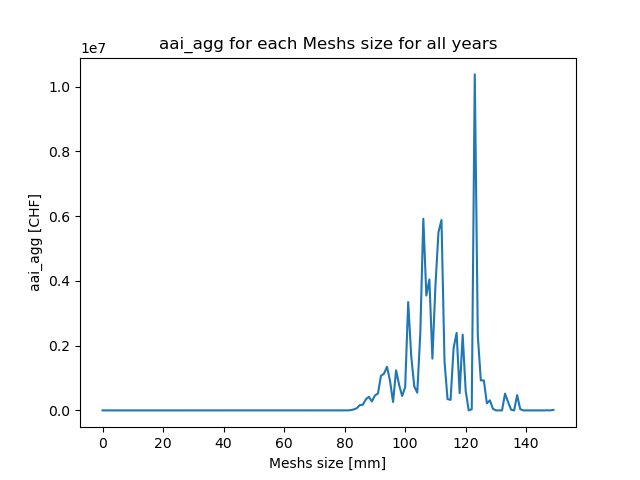

Text(0.5, 1.0, 'aai_agg for each Meshs size for all years')

In [38]:
%matplotlib notebook
plt.plot(meshs_size, dmg_meshs_size)
plt.xlabel("Meshs size [mm]")
plt.ylabel("aai_agg [CHF]")
plt.title("aai_agg for each Meshs size for all years")

In [40]:
#check if plot above is right
print(sum(dmg_meshs_size))
print(imp_infr_meshs_curve_2.aai_agg)

75875911.21268138
75875911.21268141


<IPython.core.display.Javascript object>


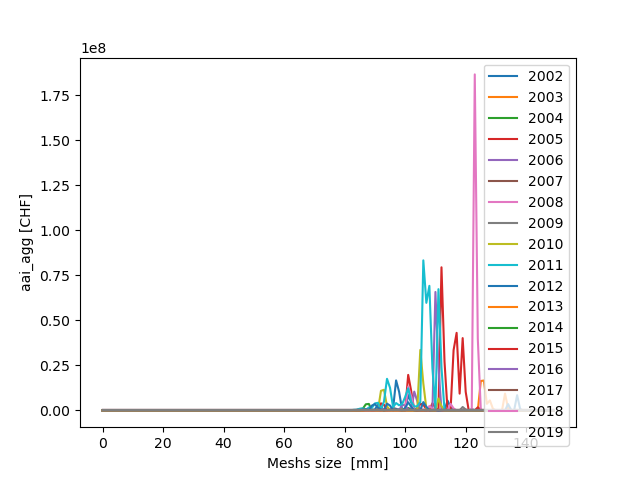

Text(0, 0.5, 'aai_agg [CHF]')

In [41]:
%matplotlib notebook
for i in range(dmg_meshs_size_year.shape[1]):
    plt.plot(meshs_size, dmg_meshs_size_year[:,i])
plt.legend(labels = dmg_meshs_size_year_label)
plt.xlabel("Meshs size  [mm]")
plt.ylabel("aai_agg [CHF]")

Outlook:
Mit Kategorien arbeiten (20-40, 40-60, 60+)

2021-02-09 13:34:34,241 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:34,243 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:34:34,245 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


<IPython.core.display.Javascript object>


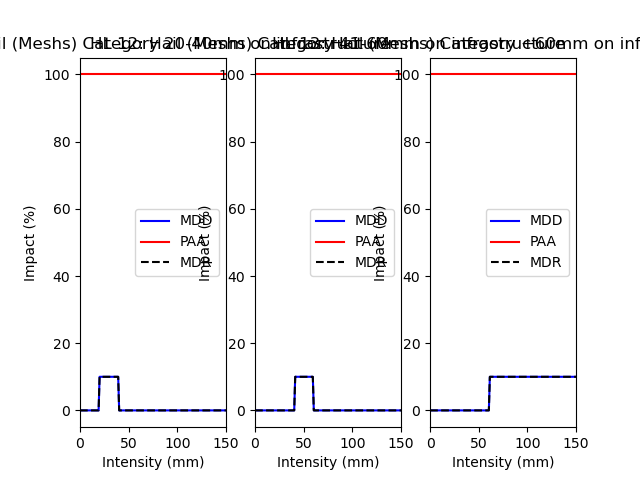

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f87da5f0190>,
      dtype=object)

In [42]:
#%% Impact_function
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
ifset_hail = ImpactFuncSet()

for i in range(3):
    imp_fun_dict = imp_fun_parameter[0]
    imp_fun = fct.create_impact_func(haz_type, 
                                 (i+11), 
                                 imp_fun_dict["L"], 
                                 imp_fun_dict["x_0"], 
                                 imp_fun_dict["k"])
    imp_fun.mdd[:] = 0
    if i == 0:
        imp_fun.mdd[20:40] = 0.1
    if i == 1:
        imp_fun.mdd[41:60] = 0.1
    if i == 2:
        imp_fun.mdd[61:] = 0.1

    ifset_hail.append(imp_fun)
ifset_hail.plot()

2021-02-09 13:39:37,703 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:39:37,705 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:39:37,709 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:39:37,854 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:39:37,856 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:39:37,859 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:39:38,273 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

<IPython.core.display.Javascript object>


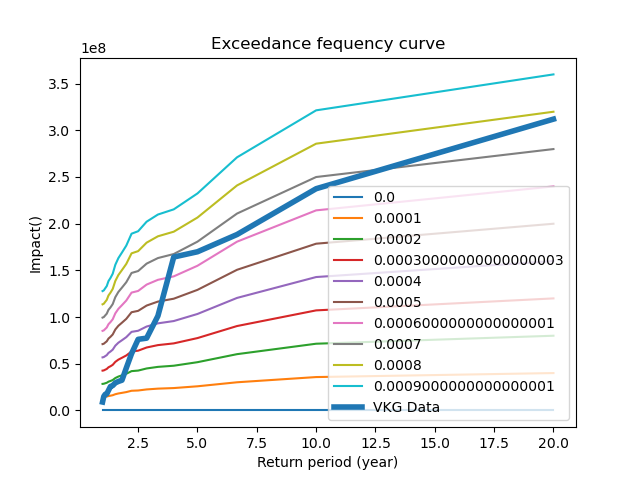

In [46]:
kat=1
freq_curve_list = []
label=[]
for percent_impact in np.arange(0, 0.001, 0.0001):
    ifset_hail = ImpactFuncSet()
    imp_fun_dict = imp_fun_parameter[0]
    imp_fun = fct.create_impact_func(haz_type, 
                                 (kat+10), 
                                 imp_fun_dict["L"], 
                                 imp_fun_dict["x_0"], 
                                 imp_fun_dict["k"])
    imp_fun.mdd[:] = 0
    if kat == 1:
        imp_fun.mdd[20:40] = percent_impact
    if kat == 2:
        imp_fun.mdd[41:60] = percent_impact
    if kat == 3:
        imp_fun.mdd[61:] = percent_impact
    ifset_hail.append(imp_fun)
    imp = Impact()
    exp_infr_meshs["if_HL"] = kat+10
    imp.calc(exp_infr_meshs, ifset_hail, haz_real, save_mat = True)
    freq_curve = imp.calc_freq_curve(imp_vkg_freq_curve.return_per)
    freq_curve_list.append(freq_curve)
    label.append(str(percent_impact))
    
%matplotlib notebook
for i in freq_curve_list:
    plt.plot(imp_vkg_freq_curve.return_per, i.impact)
plt.title("Exceedance fequency curve")
plt.xlabel("Return period (year)")
plt.ylabel("Impact()")
plt.plot(imp_vkg_freq_curve.return_per, imp_vkg_freq_curve.impact, linewidth = 4)
label.append("VKG Data")
plt.legend(label)
plt.show()

2021-02-09 13:40:07,316 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:40:07,319 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:40:07,323 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:40:07,470 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:40:07,472 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:40:07,475 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:40:07,666 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

<IPython.core.display.Javascript object>


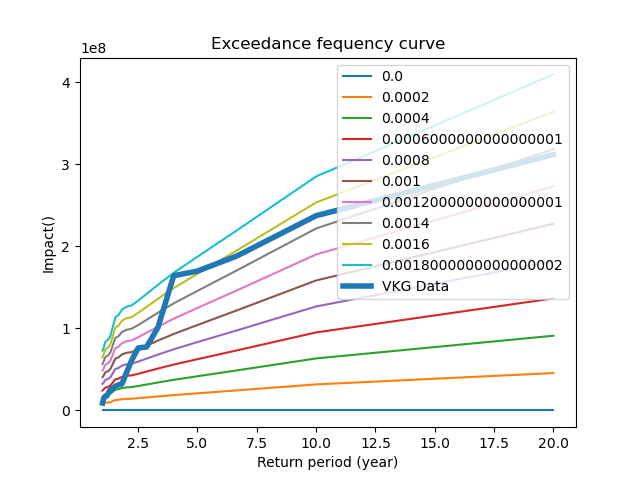

In [47]:
kat=2
freq_curve_list = []
label=[]
for percent_impact in np.arange(0, 0.002, 0.0002):
    ifset_hail = ImpactFuncSet()
    imp_fun_dict = imp_fun_parameter[0]
    imp_fun = fct.create_impact_func(haz_type, 
                                 (kat+10), 
                                 imp_fun_dict["L"], 
                                 imp_fun_dict["x_0"], 
                                 imp_fun_dict["k"])
    imp_fun.mdd[:] = 0
    if kat == 1:
        imp_fun.mdd[20:40] = percent_impact
    if kat == 2:
        imp_fun.mdd[41:60] = percent_impact
    if kat == 3:
        imp_fun.mdd[61:] = percent_impact
    ifset_hail.append(imp_fun)
    imp = Impact()
    exp_infr_meshs["if_HL"] = kat+10
    imp.calc(exp_infr_meshs, ifset_hail, haz_real, save_mat = True)
    freq_curve = imp.calc_freq_curve(imp_vkg_freq_curve.return_per)
    freq_curve_list.append(freq_curve)
    label.append(str(percent_impact))
    
%matplotlib notebook
for i in freq_curve_list:
    plt.plot(imp_vkg_freq_curve.return_per, i.impact)
plt.title("Exceedance fequency curve")
plt.xlabel("Return period (year)")
plt.ylabel("Impact()")
plt.plot(imp_vkg_freq_curve.return_per, imp_vkg_freq_curve.impact, linewidth = 4)
label.append("VKG Data")
plt.legend(label)
plt.show()

2021-02-09 13:40:27,095 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:40:27,097 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:40:27,101 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:40:27,251 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-09 13:40:27,253 - climada.engine.impact - INFO - Exposures matching centroids found in centr_HL
2021-02-09 13:40:27,256 - climada.engine.impact - INFO - Calculating damage for 68294 assets (>0) and 3294 events.
2021-02-09 13:40:27,386 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Co

<IPython.core.display.Javascript object>


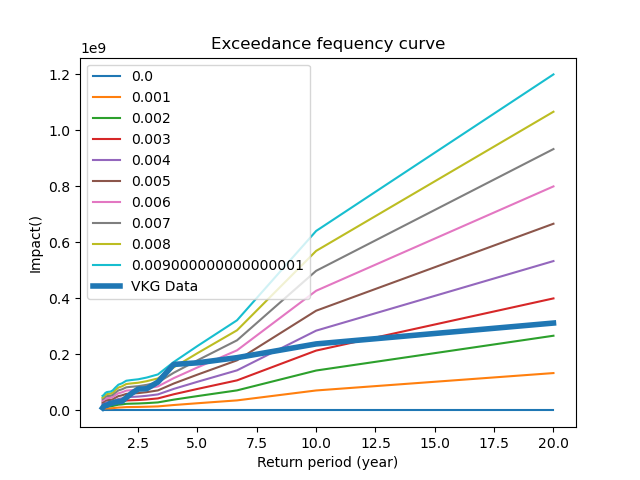

In [48]:
kat=3
freq_curve_list = []
label=[]
for percent_impact in np.arange(0, 0.01, 0.001):
    ifset_hail = ImpactFuncSet()
    imp_fun_dict = imp_fun_parameter[0]
    imp_fun = fct.create_impact_func(haz_type, 
                                 (kat+10), 
                                 imp_fun_dict["L"], 
                                 imp_fun_dict["x_0"], 
                                 imp_fun_dict["k"])
    imp_fun.mdd[:] = 0
    if kat == 1:
        imp_fun.mdd[20:40] = percent_impact
    if kat == 2:
        imp_fun.mdd[41:60] = percent_impact
    if kat == 3:
        imp_fun.mdd[61:] = percent_impact
    ifset_hail.append(imp_fun)
    imp = Impact()
    exp_infr_meshs["if_HL"] = kat+10
    imp.calc(exp_infr_meshs, ifset_hail, haz_real, save_mat = True)
    freq_curve = imp.calc_freq_curve(imp_vkg_freq_curve.return_per)
    freq_curve_list.append(freq_curve)
    label.append(str(percent_impact))
    
%matplotlib notebook
for i in freq_curve_list:
    plt.plot(imp_vkg_freq_curve.return_per, i.impact)
plt.title("Exceedance fequency curve")
plt.xlabel("Return period (year)")
plt.ylabel("Impact()")
plt.plot(imp_vkg_freq_curve.return_per, imp_vkg_freq_curve.impact, linewidth = 4)
label.append("VKG Data")
plt.legend(label)
plt.show()